In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# normalize the data
x_train = x_train/255
x_test  = x_test/255

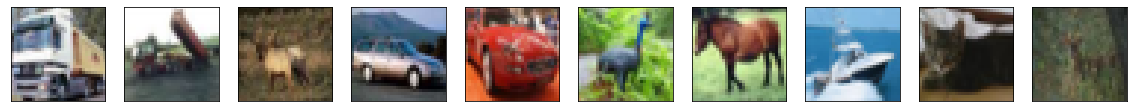

In [3]:

# FUNCTION FROM: Sundeep Rangan's Autoencorder Lab
def plot_images(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i].reshape(image_size, image_size, channel))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

plot_images(1, 10, 32, 3, x_train)

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train[0,:,:,0])

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
[[0.23137255 0.16862745 0.19607843 ... 0.61960784 0.59607843 0.58039216]
 [0.0627451  0.         0.07058824 ... 0.48235294 0.46666667 0.47843137]
 [0.09803922 0.0627451  0.19215686 ... 0.4627451  0.47058824 0.42745098]
 ...
 [0.81568627 0.78823529 0.77647059 ... 0.62745098 0.21960784 0.20784314]
 [0.70588235 0.67843137 0.72941176 ... 0.72156863 0.38039216 0.3254902 ]
 [0.69411765 0.65882353 0.70196078 ... 0.84705882 0.59215686 0.48235294]]


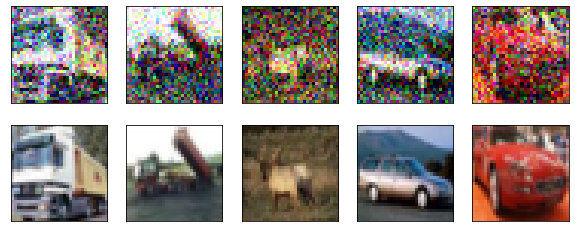

In [5]:
def Noisify(img):
    img_noisy = img + np.random.normal(loc=0.0, scale=.2, size=img.shape)
    return np.clip(img_noisy, 0, 1)

y_train = x_train
x_train = Noisify(y_train)

y_test = x_test
x_test = Noisify(x_test)

plot_images(2,5,32,3, x_train, y_train)

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = Noisify)

In [8]:
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, UpSampling2D
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

LAMBDA = 0

input_img = Input(shape=(32,32,3))

def AutoEncoder(x):
    # contract
    x = Conv2D(16, (3,3),  activation='relu', padding='same', kernel_regularizer=l2(LAMBDA))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2,2), padding='same')(x)
    
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(LAMBDA))(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2,2), padding='same')(x)
    
    # expand
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(LAMBDA))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(LAMBDA))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    # sigmoid output constrains values between 0 and 1 for output image
    x = Conv2D(3, (3,3), activation='sigmoid', padding='same', kernel_regularizer=l2(LAMBDA))(x)
    return x

model = tf.keras.Model( input_img, AutoEncoder(input_img) )
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0     

In [9]:
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss='mean_squared_error')

In [10]:
#history = model.fit(x_train, y_train, epochs=3, batch_size=256, validation_split=.1)

epochs = 3
batch_size = 512

# here's a more "manual" example
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(y_train, y_train, batch_size=batch_size):
        model.fit(x_batch, y_batch, verbose=0)
        batches += 1
        if batches >= len(x_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break


Epoch 0
Epoch 1
Epoch 2


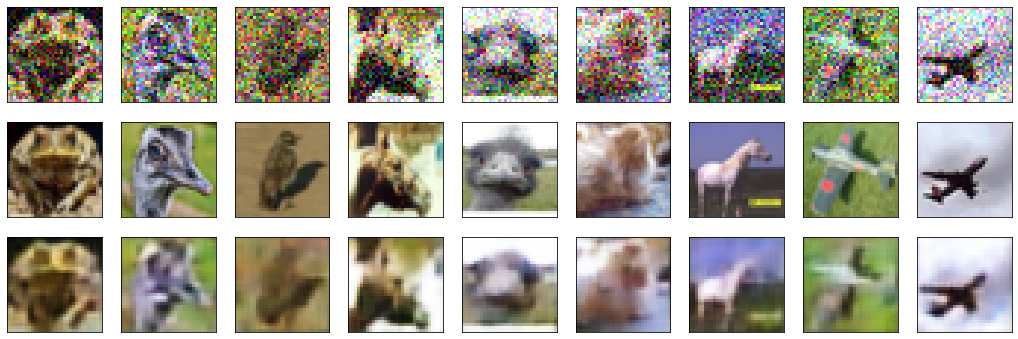

In [20]:
r = np.random.randint(0,x_train.shape[0], size=10)

yhat = model.predict(x_train[r,:,:,:])

plot_images(3,9,32,3, x_train[r,:,:,:], y_train[r,:,:,:], yhat)

In [0]:
#history = model.fit(x_train, y_train, epochs=100, batch_size=256, validation_split=.1)

epochs = 100
batch_size = 512

# here's a more "manual" example
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(y_train, y_train, batch_size=batch_size):
        model.fit(x_batch, y_batch, verbose=0)
        batches += 1
        if batches >= len(x_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
